## RDD learning with varying epsilon

In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
from lib.mu_w_2_20 import mu_mean

from lib.lif import LIF, ParamsLIF

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [62]:
q = 3                      #Dimension of learnt vector
dt = 0.001                 #Simulation timestep
DeltaT = 50               #Number of timebins over which learning rule is applied
tsim = 1000                #Total simulation time
T = int((tsim/dt)/DeltaT)  #Number of learning blocks
Nsims = 3                  #Number of repeated simulations
x_input = 0                #Input
n = 2                      #Number of neurons
sigma = 10                 #Their noise level
sigma_perturb = 20        #Perturbation noise level
mu = 1                     #Spiking threshold
tau = 1                    #Neuron timescale
eta = 1                    #Cost gradient learning rate (RDD)
epsilon = 2e5              #Weight learning rate (RDD)
epsilon_np = 1e-1          #Weight learning rate (NP)
epsilon_np_baseline = 1e-1 #Weight learning rate with baseline (NP)
tau_s = 0.20               #Output filter timescale

c = 0.5                   #Correlation coefficient
p = 0.1                    #Learning window

N = 19
wmax = 20
wmin = 2

In [7]:
#Estimate mean cost function from sims
N = 19
nsims = 1
c_mean = 0.01
fn_in = './data/output/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c_mean)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

cost2_tmp = np.zeros((nsims, hs.shape[4]))
cost2 = np.zeros((N, N))

for i in range(N):
    #print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_tmp[k,:] = cost_fun(s1, s2)
        cost2[i,j] = np.mean(cost2_tmp)

In [17]:
N = 19
nsims = 1
c_mean = 0.01
fn_cost = './data/output/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations_meancost.npz'%(N, nsims, c_mean)

#Save this so can load quickly later...
#np.savez(fn_cost, cost2 = cost2)

#Then load
costfun = np.load(fn_cost)
cost2 = costfun['cost2']

In [50]:
W_rdd_trace.shape
n = W_rdd_trace.shape[2]
nT = W_rdd_trace.shape[3]
minpt = np.array([0,0])
errs_trace = np.squeeze(W_rdd_trace[:,:,:,:,0].reshape((1,-1, n, nT)))   
errs = np.sqrt((errs_trace[:,0,:] - minpt[0])**2 + (errs_trace[:,1,:] - minpt[1])**2)
errs.shape
minpoint(cost2)
wvals

NameError: name 'wvals' is not defined

In [64]:
def minpoint(x, wvals):
    pt =  np.argwhere(x == np.min(x))[0]
    return np.array([wvals[pt[0]], wvals[pt[1]]])

wvals = np.linspace(wmin, wmax, N)
minpt = minpoint(cost2, wvals)

#Make plot of learning progress
def plottraces(W_rdd_trace, dt, DeltaT):
    
    times = np.arange(W_rdd_trace.shape[3])*DeltaT*dt
    N, _, n, T, Nsims = W_rdd_trace.shape
    grad = np.gradient(cost2)
     
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
    a=ax1.contourf(np.log(cost2), 30, origin='lower', extent=[0, wmax+1, 0, wmax+1])

    #Plot learning progress
    for idx1 in range(N):
        for idx2 in range(N):
        #for i in range(Nsims):
            i = 0
            ax1.plot(W_rdd_trace[idx1, idx2, 1,:,i], W_rdd_trace[idx1, idx2, 0,:,i], color = (1,1,1), linewidth = .6)
    
    for idx1 in range(N):
        for idx2 in range(N):
        #for i in range(Nsims):
            i = 0
            ax1.plot(W_rdd_trace[idx1, idx2, 1,-1,i], W_rdd_trace[idx1, idx2, 0,-1,i], '+', color = (1,0,0))

    n = W_rdd_trace.shape[2]
    nT = W_rdd_trace.shape[3]
    errs_trace = np.squeeze(W_rdd_trace[:,:,:,:,0].reshape((1,-1, n, nT)))   
    errs = np.sqrt((errs_trace[:,0,:] - minpt[0])**2 + (errs_trace[:,1,:] - minpt[1])**2)
    sns.tsplot(data = errs, ax = ax2, err_style = 'unit_traces', linewidth = 2, time = times)
    
    #ax1.set_title("Regression discontinuity learning traces")
    ax1.set_xlabel('$W_1$')
    ax1.set_ylabel('$W_2$')
    ax1.set_title(flags)
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('absolute $L_2$ error')

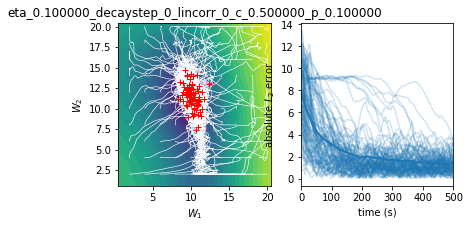

In [65]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = False
eta = 1e-1

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace, dt, DeltaT)
plt.savefig('./fig_4e.pdf')

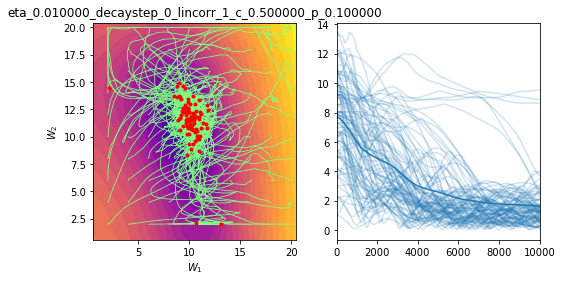

In [55]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = True
eta = 1e-2

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

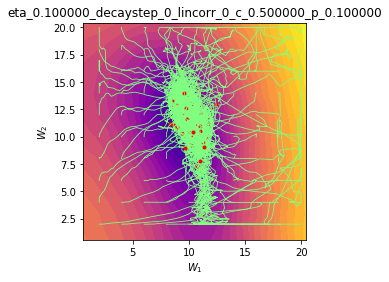

In [7]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = False
eta = 1e-1

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

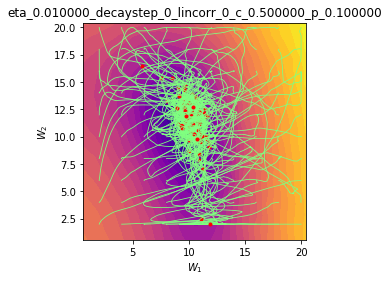

In [8]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = False
eta = 1e-2

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

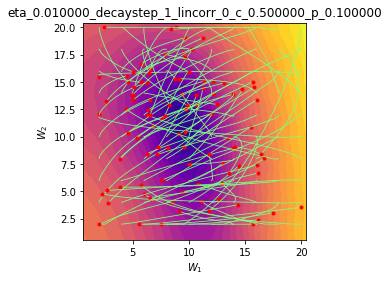

In [9]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = True
linearcorrection = False
eta = 1e-2

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

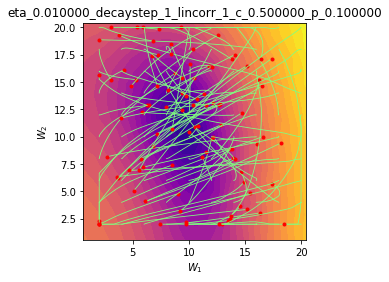

In [10]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = True
linearcorrection = True
eta = 1e-2

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

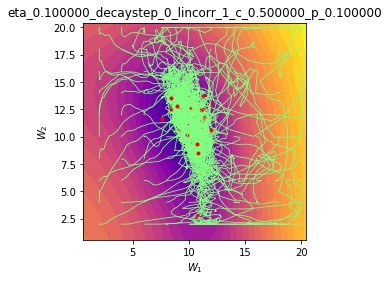

In [14]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = True
eta = 1e-1

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)

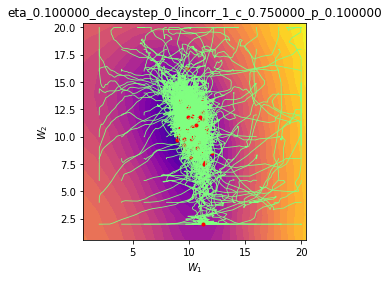

In [14]:
etas = [1, 1e-1, 1e-2]     #Cost gradient learning rate (RDD)
decaystepsize = False
linearcorrection = True
eta = 1e-1

flags = 'eta_%f_decaystep_%d_lincorr_%d_c_%f_p_%f'%(eta, decaystepsize,linearcorrection,c, p)
fn_in = './data/output/learningw_counterfactual_flags_%s.npz'%flags
sims = np.load(fn_in)
W_rdd_trace = sims['W_rdd_trace']

plottraces(W_rdd_trace)